In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
import random
import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
np.random.seed(2025)

In [5]:
from matplotlib.lines import Line2D
def plot_all_equity_lines_2(df1, df2, columns, models, title):
    
    df_profit1 = df1.copy()
    df_profit2 = df2.copy()
    df_plot = pd.DataFrame()
    
    df_plot['return_curve'] = ((1+df_profit1['BENCHMARK']).cumprod() + (1+df_profit2['BENCHMARK']).cumprod())/2

    for count, column in enumerate(columns):
        df_plot[f'equity_curve_{count}'] = ((1+df_profit1[column]).cumprod() + (1+df_profit2[column]).cumprod())/2

    
    df_plot.index = pd.to_datetime(df_plot.index)

    colors = [
        '#1f77b4', '#aec7e8',                     
        '#66c2a5', '#2ca02c', '#1b9e77', '#006d2c', '#00441b',  
        '#9467bd', '#c5b0d5', '#d783ff', '#cc79a7', '#e377c2',
        '#d62728', '#fb6a4a', '#de2d26', '#a50f15', '#67000d'  
    ]

    plt.figure(figsize=(10, 5))  

    plt.plot(df_plot.index, df_plot['return_curve'], label='Buy&Hold', color='black', linewidth=1)

    for i in range(len(columns)):
        plt.plot(df_plot.index, df_plot[f'equity_curve_{i}'], label=models[i], color=colors[i], linewidth=1)

    #plt.title(title, fontsize=14, fontweight='bold')
    #plt.xlabel('Time', fontsize=16)
    plt.ylabel('Cumulative Return', fontsize=16)

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.grid(True, which='both', linewidth=0.4)
    handles = [Line2D([0], [0], color='black', lw=1.5, label='Buy&Hold')] + \
          [Line2D([0], [0], color=colors[i], lw=1.5, label=models[i]) for i in range(len(models))]

    first_column = handles[:9]   
    second_column = handles[9:]
    
    legend1 = plt.legend(handles=first_column, loc='upper left', bbox_to_anchor=(0.01, 0.99), fontsize=8, frameon=True, framealpha=0.9)
    legend2 = plt.legend(handles=second_column, loc='upper left', bbox_to_anchor=(0.17, 0.99), fontsize=8, frameon=True, framealpha=0.9)
    
    plt.gca().add_artist(legend1)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.savefig(f"", dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
models = ['ARIMA', 'ARFIMA',
        'SVM', "SVM - ARIMA (1)", "SVM - ARFIMA (1)", "SVM - ARIMA (2)", "SVM - ARFIMA (2)",
        'XGB', "XGB - ARIMA (1)", "XGB - ARFIMA (1)", "XGB - ARIMA (2)", "XGB - ARFIMA (2)",
        "LSTM", "LSTM - ARIMA (1)", "LSTM - ARFIMA (1)", "LSTM - ARIMA (2)", "LSTM - ARFIMA (2)"]

In [7]:
def calculate_cagr(df, models = models):

    cagr_ratio_values_dict= {}

    cagr_ratio_values_dict['Benchmark'] = (((1+df['BENCHMARK']).cumprod()[-1]/1)**(1/(2023+1-2018))-1)*100
    
    return_columns = [column for column in df.columns if column.endswith('_return')]
    
    for count, column in enumerate(return_columns):
        
        cagr_ratio_values_dict[models[count]] = (((1+df[column]).cumprod()[-1]/1)**(1/(2023+1-2018))-1)*100
    
    cagr_ratio_values_df = pd.DataFrame(cagr_ratio_values_dict, index = ['CAGR'])

    return cagr_ratio_values_df

In [8]:
def calculate_asd(df, models = models):
    asd_ratio_values_dict = {}

    asd_ratio_values_dict['Benchmark'] = np.sqrt(365) * df['BENCHMARK'].std() * 100
    
    return_columns = [column for column in df.columns if column.endswith('_return')]
    
    for count, column in enumerate(return_columns):
        asd_ratio_values_dict[models[count]] = np.sqrt(365) * df[column].std() * 100
    
    asd_ratio_values_df = pd.DataFrame(asd_ratio_values_dict, index=['ASD'])

    return asd_ratio_values_df

In [9]:
def calculate_ir(df, models = models):

    ir_ratio_values_dict= {}

    ir_ratio_values_dict['Benchmark'] = cagr_ratio_values_df['Benchmark'][0] / asd_ratio_values_df['Benchmark'][0]
    
    return_columns = [column for column in df.columns if column.endswith('_return')]
    
    for count, column in enumerate(return_columns):
        
        ir_ratio_values_dict[models[count]] = cagr_ratio_values_df[models[count]][0] / asd_ratio_values_df[models[count]][0]
    
    ir_ratio_values_df = pd.DataFrame(ir_ratio_values_dict, index = ['IR'])

    return ir_ratio_values_df

In [10]:
def calculate_sr(df, models = models):

    sr_ratio_values_dict= {}
    
    downside_deviations = np.minimum(df['BENCHMARK'], 0)

    asd_downside = np.sqrt(252)*(np.sum((downside_deviations - downside_deviations.mean())**2)/(len(downside_deviations)-1))**(1/2)*100

    sr_ratio_values_dict['Benchmark'] = cagr_ratio_values_df['Benchmark'][0] / asd_downside
    
    return_columns = [column for column in df.columns if column.endswith('_return')]
    
    for count, column in enumerate(return_columns):

        downside_deviations = np.minimum(df[column], 0)
        asd_downside = np.sqrt(252)*(np.sum((downside_deviations - downside_deviations.mean())**2)/(len(downside_deviations)-1))**(1/2)*100
        
        sr_ratio_values_dict[models[count]] = cagr_ratio_values_df[models[count]][0] / asd_downside
    
    sr_ratio_values_df = pd.DataFrame(sr_ratio_values_dict, index = ['SR'])

    return sr_ratio_values_df

In [11]:
def calculate_md(df, models = models):

    md_ratio_values_dict= {}
    
    cumulative = (1+df['BENCHMARK']).cumprod() - 1
    wealth_index = 100*(1+cumulative)
    previous_peak = wealth_index.cummax()
    drawdown = (wealth_index - previous_peak) / previous_peak
    max_drawdown = np.abs(drawdown.min()*100)

    md_ratio_values_dict['Benchmark'] = max_drawdown
    
    return_columns = [column for column in df.columns if column.endswith('_return')]
    
    for count, column in enumerate(return_columns):

        cumulative = (1+df[column]).cumprod() - 1
        wealth_index = 100*(1+cumulative)
        previous_peak = wealth_index.cummax()
        drawdown = (wealth_index - previous_peak) / previous_peak
        max_drawdown = np.abs(drawdown.min()*100)
        
        md_ratio_values_dict[models[count]] = max_drawdown
    
    md_ratio_values_df = pd.DataFrame(md_ratio_values_dict, index = ['MD'])

    return md_ratio_values_df

In [12]:
def calculate_adj_ir(df, models = models):

    adj_ir_ratio_values_dict= {}

    adj_ir_ratio_values_dict['Benchmark'] = (cagr_ratio_values_df['Benchmark'][0]**2) * np.sign(cagr_ratio_values_df['Benchmark'][0]) / (asd_ratio_values_df['Benchmark'][0] * md_ratio_values_df['Benchmark'][0])
    
    return_columns = [column for column in df.columns if column.endswith('_return')]
    
    for count, column in enumerate(return_columns):
        
        adj_ir_ratio_values_dict[models[count]] = (cagr_ratio_values_df[models[count]][0]**2) * np.sign(cagr_ratio_values_df[models[count]][0]) / (asd_ratio_values_df[models[count]][0] * md_ratio_values_df[models[count]][0])
    
    adj_ir_ratio_values_df = pd.DataFrame(adj_ir_ratio_values_dict, index = ['Adj IR'])

    return adj_ir_ratio_values_df

In [13]:
columns_equity = []
for model in models:
    columns_equity.append(model+'_strategy_return')
columns_equity

['ARIMA_strategy_return',
 'ARFIMA_strategy_return',
 'SVM_strategy_return',
 'SVM - ARIMA (1)_strategy_return',
 'SVM - ARFIMA (1)_strategy_return',
 'SVM - ARIMA (2)_strategy_return',
 'SVM - ARFIMA (2)_strategy_return',
 'XGB_strategy_return',
 'XGB - ARIMA (1)_strategy_return',
 'XGB - ARFIMA (1)_strategy_return',
 'XGB - ARIMA (2)_strategy_return',
 'XGB - ARFIMA (2)_strategy_return',
 'LSTM_strategy_return',
 'LSTM - ARIMA (1)_strategy_return',
 'LSTM - ARFIMA (1)_strategy_return',
 'LSTM - ARIMA (2)_strategy_return',
 'LSTM - ARFIMA (2)_strategy_return']

In [14]:
file_path = ''

with open(file_path, 'rb') as f:
    df_profit_sp500_costs = pickle.load(f)
    trades_sp500_costs = pickle.load(f)
    long_sp500_costs = pickle.load(f)
    short_sp500_costs = pickle.load(f)
    days_in_market_sp500_costs = pickle.load(f)

In [15]:
file_path = ''

with open(file_path, 'rb') as f:
    df_profit_btc_costs = pickle.load(f)
    trades_btc_costs = pickle.load(f)
    long_btc_costs = pickle.load(f)
    short_btc_costs = pickle.load(f)
    days_in_market_btc_costs = pickle.load(f)

In [16]:
df_profit_sp500_costs.loc['2018-01-01':]

,BENCHMARK,ARIMA,ARFIMA,SVM,SVM - ARIMA (1),SVM - ARFIMA (1),SVM - ARIMA (2),SVM - ARFIMA (2),XGB,XGB - ARIMA (1),...,LSTM_signal,LSTM_strategy_return,LSTM - ARIMA (1)_signal,LSTM - ARIMA (1)_strategy_return,LSTM - ARFIMA (1)_signal,LSTM - ARFIMA (1)_strategy_return,LSTM - ARIMA (2)_signal,LSTM - ARIMA (2)_strategy_return,LSTM - ARFIMA (2)_signal,LSTM - ARFIMA (2)_strategy_return
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.008303,0.000000,0.000584,-0.000645,-0.000890,-0.000534,-8.803517e-04,-0.000867,0.000694,0.000453,...,1.0,0.008303,1.0,0.008303,1.0,-0.000050,1.0,-0.000050,1.0,0.008303
2018-01-03,0.006399,0.000000,0.000370,-0.002988,-0.002460,-0.002804,-2.416471e-03,-0.003317,0.000272,0.000127,...,-1.0,-0.000050,-1.0,-0.000050,1.0,0.006349,1.0,0.006349,-1.0,-0.000050
2018-01-04,0.004029,0.000000,0.000410,-0.003785,-0.003910,-0.003821,-3.297155e-03,-0.003569,0.000100,-0.000982,...,1.0,0.003979,-1.0,-0.004079,1.0,0.004029,1.0,0.004029,-1.0,-0.004079
2018-01-05,0.007034,0.000000,0.000444,-0.002731,-0.002729,-0.002626,-1.747063e-03,-0.001615,0.000366,-0.000233,...,1.0,0.007034,-1.0,-0.007034,1.0,0.007034,1.0,0.007034,0.0,-0.007034
2018-01-08,0.001662,0.000000,0.000413,-0.002998,-0.002695,-0.002966,-2.768403e-03,-0.003113,0.000399,0.000145,...,1.0,0.001662,-1.0,-0.001662,1.0,0.001662,1.0,0.001662,1.0,-0.000050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.001660,-0.003121,-0.001021,0.000065,0.000065,0.001282,-2.114751e-03,0.001304,0.001284,0.000790,...,1.0,0.001660,1.0,0.001660,-1.0,-0.000050,-1.0,-0.001710,-1.0,-0.000050
2023-12-26,0.004232,0.000725,0.000119,0.003446,0.003446,0.000493,1.426045e-03,0.000364,0.000329,0.001279,...,1.0,0.004232,1.0,0.004232,1.0,0.004182,1.0,-0.000050,1.0,0.004182
2023-12-27,0.001430,-0.000547,0.001742,0.000760,0.000760,0.001313,-3.146477e-04,0.002643,0.000695,0.000336,...,1.0,0.001430,1.0,0.001430,1.0,0.001430,-1.0,-0.001480,1.0,0.001430


In [17]:
df_profit_btc_costs

,BENCHMARK,ARIMA,ARFIMA,SVM,SVM - ARIMA (1),SVM - ARFIMA (1),SVM - ARIMA (2),SVM - ARFIMA (2),XGB,XGB - ARIMA (1),...,LSTM_signal,LSTM_strategy_return,LSTM - ARIMA (1)_signal,LSTM - ARIMA (1)_strategy_return,LSTM - ARFIMA (1)_signal,LSTM - ARFIMA (1)_strategy_return,LSTM - ARIMA (2)_signal,LSTM - ARIMA (2)_strategy_return,LSTM - ARFIMA (2)_signal,LSTM - ARFIMA (2)_strategy_return
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-0.035263,0.0,0.016491,0.005132,0.005132,0.006505,0.005132,0.014359,-0.003726,-0.000601,...,1.0,-0.036263,1.0,-0.036263,1.0,-0.036263,1.0,-0.036263,1.0,-0.036263
2018-01-02,0.097011,0.0,-0.002686,0.003941,0.003941,0.005152,0.003941,-0.003427,-0.003947,0.001357,...,0.0,0.097011,-1.0,-0.001000,1.0,0.097011,0.0,0.097011,-1.0,-0.001000
2018-01-03,0.014611,0.0,0.001029,0.003993,0.003993,0.004645,0.003993,0.000532,-0.008133,0.003616,...,1.0,0.014611,1.0,0.013611,-1.0,-0.001000,1.0,0.014611,1.0,0.013611
2018-01-04,0.026196,0.0,-0.001416,0.002759,0.002759,0.002864,0.002759,-0.003570,0.000468,-0.001614,...,1.0,0.026196,1.0,0.026196,-1.0,-0.027196,1.0,0.026196,-1.0,-0.001000
2018-01-05,0.117333,0.0,0.010314,0.005667,0.005667,0.009411,0.005667,0.009107,-0.006247,0.000845,...,1.0,0.117333,1.0,0.117333,-1.0,-0.117333,1.0,0.117333,1.0,0.116333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,-0.025055,0.0,0.000385,-0.003508,-0.002746,-0.002120,-0.004437,-0.002826,-0.002742,0.001979,...,1.0,-0.025055,-1.0,0.025055,1.0,-0.025055,-1.0,0.025055,0.0,-0.025055
2023-12-27,0.021694,0.0,0.001512,0.001002,0.003202,0.004225,0.000928,0.000386,0.001887,0.003600,...,0.0,0.021694,-1.0,-0.021694,-1.0,-0.001000,-1.0,-0.021694,0.0,0.021694
2023-12-28,-0.018760,0.0,-0.000084,0.001119,0.001781,0.001564,0.001254,0.003010,-0.000467,0.002213,...,1.0,-0.018760,-1.0,0.018760,1.0,-0.019760,-1.0,0.018760,0.0,-0.018760


In [18]:
df_profit_sp500_costs_reindex = df_profit_sp500_costs.reindex(df_profit_btc_costs.index, fill_value=0)
df_profit_sp500_costs_reindex

,BENCHMARK,ARIMA,ARFIMA,SVM,SVM - ARIMA (1),SVM - ARFIMA (1),SVM - ARIMA (2),SVM - ARFIMA (2),XGB,XGB - ARIMA (1),...,LSTM_signal,LSTM_strategy_return,LSTM - ARIMA (1)_signal,LSTM - ARIMA (1)_strategy_return,LSTM - ARFIMA (1)_signal,LSTM - ARFIMA (1)_strategy_return,LSTM - ARIMA (2)_signal,LSTM - ARIMA (2)_strategy_return,LSTM - ARFIMA (2)_signal,LSTM - ARFIMA (2)_strategy_return
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2018-01-02,0.008303,0.000000,0.000584,-0.000645,-0.000890,-0.000534,-8.803517e-04,-0.000867,0.000694,0.000453,...,1.0,0.008303,1.0,0.008303,1.0,-0.000050,1.0,-0.000050,1.0,0.008303
2018-01-03,0.006399,0.000000,0.000370,-0.002988,-0.002460,-0.002804,-2.416471e-03,-0.003317,0.000272,0.000127,...,-1.0,-0.000050,-1.0,-0.000050,1.0,0.006349,1.0,0.006349,-1.0,-0.000050
2018-01-04,0.004029,0.000000,0.000410,-0.003785,-0.003910,-0.003821,-3.297155e-03,-0.003569,0.000100,-0.000982,...,1.0,0.003979,-1.0,-0.004079,1.0,0.004029,1.0,0.004029,-1.0,-0.004079
2018-01-05,0.007034,0.000000,0.000444,-0.002731,-0.002729,-0.002626,-1.747063e-03,-0.001615,0.000366,-0.000233,...,1.0,0.007034,-1.0,-0.007034,1.0,0.007034,1.0,0.007034,0.0,-0.007034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,0.004232,0.000725,0.000119,0.003446,0.003446,0.000493,1.426045e-03,0.000364,0.000329,0.001279,...,1.0,0.004232,1.0,0.004232,1.0,0.004182,1.0,-0.000050,1.0,0.004182
2023-12-27,0.001430,-0.000547,0.001742,0.000760,0.000760,0.001313,-3.146477e-04,0.002643,0.000695,0.000336,...,1.0,0.001430,1.0,0.001430,1.0,0.001430,-1.0,-0.001480,1.0,0.001430
2023-12-28,0.000370,0.000183,-0.000899,-0.000393,-0.000393,-0.000351,3.400504e-04,-0.001106,0.000650,0.000535,...,1.0,0.000370,1.0,0.000370,-1.0,-0.000050,1.0,-0.000050,-1.0,-0.000050


In [19]:
df_profit_btc_costs

,BENCHMARK,ARIMA,ARFIMA,SVM,SVM - ARIMA (1),SVM - ARFIMA (1),SVM - ARIMA (2),SVM - ARFIMA (2),XGB,XGB - ARIMA (1),...,LSTM_signal,LSTM_strategy_return,LSTM - ARIMA (1)_signal,LSTM - ARIMA (1)_strategy_return,LSTM - ARFIMA (1)_signal,LSTM - ARFIMA (1)_strategy_return,LSTM - ARIMA (2)_signal,LSTM - ARIMA (2)_strategy_return,LSTM - ARFIMA (2)_signal,LSTM - ARFIMA (2)_strategy_return
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-0.035263,0.0,0.016491,0.005132,0.005132,0.006505,0.005132,0.014359,-0.003726,-0.000601,...,1.0,-0.036263,1.0,-0.036263,1.0,-0.036263,1.0,-0.036263,1.0,-0.036263
2018-01-02,0.097011,0.0,-0.002686,0.003941,0.003941,0.005152,0.003941,-0.003427,-0.003947,0.001357,...,0.0,0.097011,-1.0,-0.001000,1.0,0.097011,0.0,0.097011,-1.0,-0.001000
2018-01-03,0.014611,0.0,0.001029,0.003993,0.003993,0.004645,0.003993,0.000532,-0.008133,0.003616,...,1.0,0.014611,1.0,0.013611,-1.0,-0.001000,1.0,0.014611,1.0,0.013611
2018-01-04,0.026196,0.0,-0.001416,0.002759,0.002759,0.002864,0.002759,-0.003570,0.000468,-0.001614,...,1.0,0.026196,1.0,0.026196,-1.0,-0.027196,1.0,0.026196,-1.0,-0.001000
2018-01-05,0.117333,0.0,0.010314,0.005667,0.005667,0.009411,0.005667,0.009107,-0.006247,0.000845,...,1.0,0.117333,1.0,0.117333,-1.0,-0.117333,1.0,0.117333,1.0,0.116333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,-0.025055,0.0,0.000385,-0.003508,-0.002746,-0.002120,-0.004437,-0.002826,-0.002742,0.001979,...,1.0,-0.025055,-1.0,0.025055,1.0,-0.025055,-1.0,0.025055,0.0,-0.025055
2023-12-27,0.021694,0.0,0.001512,0.001002,0.003202,0.004225,0.000928,0.000386,0.001887,0.003600,...,0.0,0.021694,-1.0,-0.021694,-1.0,-0.001000,-1.0,-0.021694,0.0,0.021694
2023-12-28,-0.018760,0.0,-0.000084,0.001119,0.001781,0.001564,0.001254,0.003010,-0.000467,0.002213,...,1.0,-0.018760,-1.0,0.018760,1.0,-0.019760,-1.0,0.018760,0.0,-0.018760


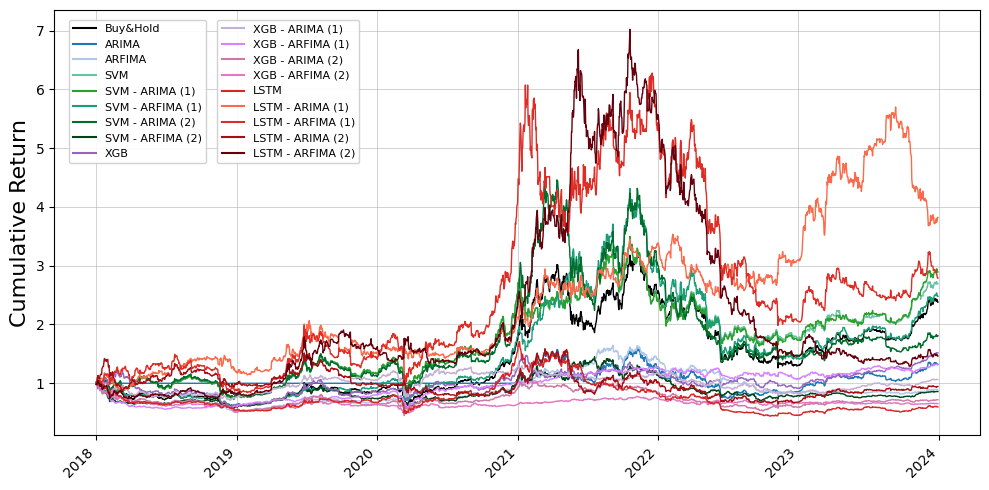

In [21]:
df_plot_long_short = plot_all_equity_lines_2(df1 = df_profit_sp500_costs_reindex, df2 = df_profit_btc_costs, columns = columns_equity, models = models, title = 'equity_5')

In [99]:
df_plot_long_short.columns = ["BENCHMARK"] +  columns_equity

In [100]:
df_plot_long_short_returns = df_plot_long_short.pct_change()
df_plot_long_short_returns

,BENCHMARK,ARIMA_strategy_return,ARFIMA_strategy_return,SVM_strategy_return,SVM - ARIMA (1)_strategy_return,SVM - ARFIMA (1)_strategy_return,SVM - ARIMA (2)_strategy_return,SVM - ARFIMA (2)_strategy_return,XGB_strategy_return,XGB - ARIMA (1)_strategy_return,XGB - ARFIMA (1)_strategy_return,XGB - ARIMA (2)_strategy_return,XGB - ARFIMA (2)_strategy_return,LSTM_strategy_return,LSTM - ARIMA (1)_strategy_return,LSTM - ARFIMA (1)_strategy_return,LSTM - ARIMA (2)_strategy_return,LSTM - ARFIMA (2)_strategy_return
Date,,,,,,,,,,,,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.051861,0.000000,0.003738,0.047584,0.047584,0.047584,0.047584,-0.004719,-0.045241,0.047981,-0.004719,-0.000516,-0.000516,0.051838,0.003738,0.047584,0.047584,0.003738
2018-01-03,0.010604,0.000000,0.009922,0.004374,0.004374,0.004374,0.004374,-0.003247,-0.003704,0.010669,-0.007715,-0.004423,-0.004423,0.007454,0.006623,0.002572,0.010595,0.006623
2018-01-04,0.015425,0.000000,0.001563,0.011663,0.011663,0.011663,0.011663,-0.015478,-0.010346,-0.000549,-0.014887,-0.000511,-0.010631,0.015431,0.010812,-0.011961,0.015466,-0.002564
2018-01-05,0.064344,0.000000,0.060479,0.058460,0.058460,0.058460,0.058460,-0.004087,-0.051166,-0.003367,-0.004119,0.003598,0.003199,0.064493,0.055066,-0.055671,0.064546,0.053738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,-0.014337,-0.014006,-0.001158,0.015967,0.001034,0.018172,0.016967,0.006601,0.011583,0.002773,0.004142,0.007605,-0.002764,-0.007894,0.017990,-0.018424,0.010125,-0.013538
2023-12-27,0.014138,0.011309,0.005043,0.000048,0.013182,-0.000289,-0.015291,-0.001249,0.000561,0.002412,0.001406,-0.002381,-0.001201,0.009675,-0.013954,-0.000436,-0.009794,0.013569
2023-12-28,-0.011716,-0.010482,-0.003441,-0.011246,-0.011549,-0.013981,-0.000695,-0.000158,0.000238,-0.000574,0.000026,0.002990,0.000579,-0.007506,0.012509,-0.015179,0.007593,-0.011347


In [101]:
cagr_ratio_values_df = calculate_cagr(df_plot_long_short_returns)
asd_ratio_values_df = calculate_asd(df_plot_long_short_returns)
md_ratio_values_df = calculate_md(df_plot_long_short_returns)
ir_ratio_values_df = calculate_ir(df_plot_long_short_returns)
adj_ir_ratio_values_df = calculate_adj_ir(df_plot_long_short_returns)
sr_ratio_values_df = calculate_sr(df_plot_long_short_returns)

df_sp500_stats = pd.DataFrame(columns = models, dtype = int)
df_sp500_stats = pd.concat([df_sp500_stats, cagr_ratio_values_df])
df_sp500_stats = pd.concat([df_sp500_stats, asd_ratio_values_df])
df_sp500_stats = pd.concat([df_sp500_stats, md_ratio_values_df])
df_sp500_stats = pd.concat([df_sp500_stats, ir_ratio_values_df])
df_sp500_stats = pd.concat([df_sp500_stats, adj_ir_ratio_values_df])
df_sp500_stats = pd.concat([df_sp500_stats, sr_ratio_values_df])

df_sp500_stats

,ARIMA,ARFIMA,SVM,SVM - ARIMA (1),SVM - ARFIMA (1),SVM - ARIMA (2),SVM - ARFIMA (2),XGB,XGB - ARIMA (1),XGB - ARFIMA (1),XGB - ARIMA (2),XGB - ARFIMA (2),LSTM,LSTM - ARIMA (1),LSTM - ARFIMA (1),LSTM - ARIMA (2),LSTM - ARFIMA (2),Benchmark
CAGR,4.710991,-1.610906,18.305457,19.723711,16.687100,10.728065,-2.193988,6.894751,1.022895,5.082150,-5.040176,-6.543779,-7.914169,25.413279,18.994107,-0.621206,6.884531,15.899227
ASD,25.948804,23.861616,37.805446,37.883369,37.972061,43.058992,25.794044,25.996165,23.765728,19.853345,21.794396,18.390854,30.815504,36.936255,48.380360,34.475494,42.199019,38.453024
MD,54.198454,52.243538,52.246509,53.309456,68.305602,69.574961,51.418242,50.747712,38.156561,42.667275,48.061947,56.434243,74.160931,35.427466,68.384682,59.329974,81.662938,61.358107
IR,0.181549,-0.067510,0.484202,0.520643,0.439457,0.249148,-0.085058,0.265222,0.043041,0.255985,-0.231260,-0.355817,-0.256824,0.688031,0.392600,-0.018019,0.163144,0.413471
Adj IR,0.015780,-0.002082,0.169648,0.192630,0.107360,0.038417,-0.003629,0.036034,0.001154,0.030491,-0.024252,-0.041258,-0.027407,0.493547,0.109046,-0.000189,0.013754,0.107139
SR,0.334232,-0.118549,0.911247,0.982177,0.820092,0.472157,-0.157002,0.500921,0.074962,0.448824,-0.418367,-0.612298,-0.461311,1.418964,0.748354,-0.034038,0.319941,0.781350


In [22]:
file_path = ''

with open(file_path, 'rb') as f:
    df_profit_sp500_costs = pickle.load(f)
    trades_sp500_costs = pickle.load(f)
    long_sp500_costs = pickle.load(f)
    short_sp500_costs = pickle.load(f)
    days_in_market_sp500_costs = pickle.load(f)

In [23]:
file_path = ''

with open(file_path, 'rb') as f:
    df_profit_btc_costs = pickle.load(f)
    trades_btc_costs = pickle.load(f)
    long_btc_costs = pickle.load(f)
    short_btc_costs = pickle.load(f)
    days_in_market_btc_costs = pickle.load(f)

In [24]:
df_profit_sp500_costs_reindex = df_profit_sp500_costs.reindex(df_profit_btc_costs.index, fill_value=0)
df_profit_sp500_costs_reindex

,BENCHMARK,ARIMA,ARFIMA,SVM,SVM - ARIMA (1),SVM - ARFIMA (1),SVM - ARIMA (2),SVM - ARFIMA (2),XGB,XGB - ARIMA (1),...,LSTM_signal,LSTM_strategy_return,LSTM - ARIMA (1)_signal,LSTM - ARIMA (1)_strategy_return,LSTM - ARFIMA (1)_signal,LSTM - ARFIMA (1)_strategy_return,LSTM - ARIMA (2)_signal,LSTM - ARIMA (2)_strategy_return,LSTM - ARFIMA (2)_signal,LSTM - ARFIMA (2)_strategy_return
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2018-01-02,0.008303,0.000000,0.000584,-0.000645,-0.000890,-0.000534,-8.803517e-04,-0.000867,0.000694,0.000453,...,1.0,0.008303,1.0,0.008303,1.0,0.008253,1.0,0.008253,1.0,0.008303
2018-01-03,0.006399,0.000000,0.000370,-0.002988,-0.002460,-0.002804,-2.416471e-03,-0.003317,0.000272,0.000127,...,-1.0,-0.000050,-1.0,-0.000050,1.0,0.006399,1.0,0.006399,-1.0,-0.000050
2018-01-04,0.004029,0.000000,0.000410,-0.003785,-0.003910,-0.003821,-3.297155e-03,-0.003569,0.000100,-0.000982,...,1.0,0.003979,-1.0,0.000000,1.0,0.004029,1.0,0.004029,-1.0,0.000000
2018-01-05,0.007034,0.000000,0.000444,-0.002731,-0.002729,-0.002626,-1.747063e-03,-0.001615,0.000366,-0.000233,...,1.0,0.007034,-1.0,0.000000,1.0,0.007034,1.0,0.007034,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,0.004232,0.000725,0.000119,0.003446,0.003446,0.000493,1.426045e-03,0.000364,0.000329,0.001279,...,1.0,0.004232,1.0,0.004232,1.0,0.004182,1.0,0.004182,1.0,0.004182
2023-12-27,0.001430,-0.000547,0.001742,0.000760,0.000760,0.001313,-3.146477e-04,0.002643,0.000695,0.000336,...,1.0,0.001430,1.0,0.001430,1.0,0.001430,-1.0,-0.000050,1.0,0.001430
2023-12-28,0.000370,0.000183,-0.000899,-0.000393,-0.000393,-0.000351,3.400504e-04,-0.001106,0.000650,0.000535,...,1.0,0.000370,1.0,0.000370,-1.0,-0.000050,1.0,0.000320,-1.0,-0.000050


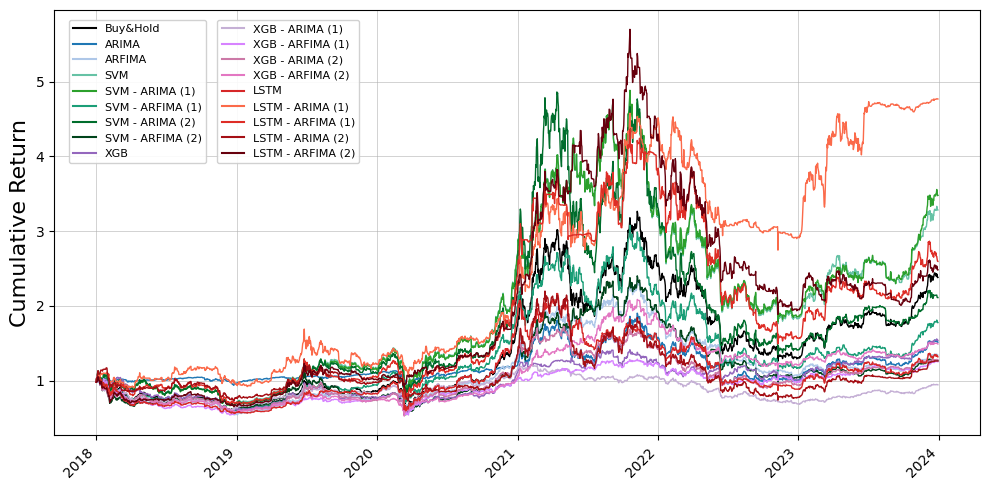

In [26]:
df_plot_long_only = plot_all_equity_lines_2(df1 = df_profit_sp500_costs_reindex, df2 = df_profit_btc_costs, columns = columns_equity, models = models, title = 'equity_6')

In [106]:
df_plot_long_only.columns = ["BENCHMARK"] +  columns_equity

In [108]:
cagr_ratio_values_df = calculate_cagr(df_plot_long_only_returns)
asd_ratio_values_df = calculate_asd(df_plot_long_only_returns)
md_ratio_values_df = calculate_md(df_plot_long_only_returns)
ir_ratio_values_df = calculate_ir(df_plot_long_only_returns)
adj_ir_ratio_values_df = calculate_adj_ir(df_plot_long_only_returns)
sr_ratio_values_df = calculate_sr(df_plot_long_only_returns)

df_sp500_stats = pd.DataFrame(columns = models, dtype = int)
df_sp500_stats = pd.concat([df_sp500_stats, cagr_ratio_values_df])
df_sp500_stats = pd.concat([df_sp500_stats, asd_ratio_values_df])
df_sp500_stats = pd.concat([df_sp500_stats, md_ratio_values_df])
df_sp500_stats = pd.concat([df_sp500_stats, ir_ratio_values_df])
df_sp500_stats = pd.concat([df_sp500_stats, adj_ir_ratio_values_df])
df_sp500_stats = pd.concat([df_sp500_stats, sr_ratio_values_df])

df_sp500_stats

,ARIMA,ARFIMA,SVM,SVM - ARIMA (1),SVM - ARFIMA (1),SVM - ARIMA (2),SVM - ARFIMA (2),XGB,XGB - ARIMA (1),XGB - ARFIMA (1),XGB - ARIMA (2),XGB - ARFIMA (2),LSTM,LSTM - ARIMA (1),LSTM - ARFIMA (1),LSTM - ARIMA (2),LSTM - ARFIMA (2),Benchmark
CAGR,7.171414,5.333649,22.284287,23.466451,10.402497,13.614420,4.339034,7.454448,-0.928514,4.165169,4.543278,7.212973,5.056316,30.126721,17.590140,4.291573,16.719911,15.899227
ASD,24.270981,27.799527,40.705780,40.772794,36.382207,43.388411,29.658653,24.729479,23.327424,21.605442,26.433016,22.963584,32.065688,33.261920,37.883085,33.458330,33.186478,38.453024
MD,49.866077,54.814247,63.799037,63.409211,63.300919,72.244717,58.933960,45.846936,43.901021,48.133511,47.876747,49.970847,59.812989,39.993562,65.807296,66.320993,66.887673,61.358107
IR,0.295473,0.191861,0.547448,0.575542,0.285923,0.313780,0.146299,0.301440,-0.039804,0.192783,0.171879,0.314105,0.157686,0.905742,0.464327,0.128266,0.503817,0.413471
Adj IR,0.042493,0.018669,0.191217,0.212996,0.046987,0.059131,0.010771,0.049012,-0.000842,0.016682,0.016310,0.045339,0.013330,0.682286,0.124114,0.008300,0.125939,0.107139
SR,0.552223,0.346778,1.038032,1.095084,0.526914,0.592826,0.263595,0.530417,-0.068933,0.341481,0.313305,0.561927,0.285370,1.790379,0.861308,0.241523,0.979632,0.781350


In [107]:
df_plot_long_only_returns = df_plot_long_only.pct_change()
df_plot_long_only_returns

,BENCHMARK,ARIMA_strategy_return,ARFIMA_strategy_return,SVM_strategy_return,SVM - ARIMA (1)_strategy_return,SVM - ARFIMA (1)_strategy_return,SVM - ARIMA (2)_strategy_return,SVM - ARFIMA (2)_strategy_return,XGB_strategy_return,XGB - ARIMA (1)_strategy_return,XGB - ARFIMA (1)_strategy_return,XGB - ARIMA (2)_strategy_return,XGB - ARFIMA (2)_strategy_return,LSTM_strategy_return,LSTM - ARIMA (1)_strategy_return,LSTM - ARFIMA (1)_strategy_return,LSTM - ARIMA (2)_strategy_return,LSTM - ARFIMA (2)_strategy_return
Date,,,,,,,,,,,,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.051861,0.004152,0.003738,0.047584,0.047584,0.047584,0.047584,-0.000491,0.004152,0.052132,-0.000491,0.003712,0.003712,0.051838,0.003738,0.051813,0.051813,0.003738
2018-01-03,0.010604,0.003213,0.009922,0.007509,0.007509,0.007509,0.007509,0.000000,0.003213,0.010676,0.003235,0.003273,0.003273,0.007454,0.006623,0.002612,0.010602,0.006623
2018-01-04,0.015425,0.002029,0.001563,0.013557,0.013557,0.013557,0.013557,0.000000,0.002029,-0.000547,-0.000026,0.012241,0.002067,0.015431,0.012884,0.001974,0.015420,-0.000492
2018-01-05,0.064344,0.003550,0.060479,0.061482,0.061482,0.061482,0.061482,0.057063,0.003550,0.000000,0.056881,0.061397,0.060138,0.064493,0.058468,0.003454,0.064316,0.057188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,-0.014337,-0.010088,-0.005404,0.001221,0.000458,0.001807,0.001135,0.002632,0.002624,0.000079,0.003726,0.002869,0.000000,-0.012353,0.001109,-0.017291,0.001766,-0.014551
2023-12-27,0.014138,0.010402,0.007943,0.015121,0.015304,0.012449,-0.000014,0.000891,0.008730,0.004231,0.001293,0.000971,0.000908,0.012758,0.000376,-0.000340,-0.000021,0.014276
2023-12-28,-0.011716,-0.008954,-0.006145,-0.013420,-0.013597,-0.010839,-0.014293,-0.007473,-0.006965,-0.002320,-0.001565,-0.000034,-0.000033,-0.010418,0.000097,-0.014402,0.000136,-0.011997
